In [1]:
!pip install --upgrade albumentations 

     |████████████████████████████████| 102kB 2.6MB/s 
     |████████████████████████████████| 37.2MB 81kB/s 
  Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [2]:
import os
from glob import glob
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import matplotlib.patches as patches
from bokeh.models import ColumnDataSource, HoverTool, Panel
from bokeh.plotting import figure
from bokeh.io import output_notebook, show, output_file
import cv2
import albumentations
from albumentations.pytorch.transforms import ToTensorV2

In [3]:
base_dir = "/content/drive/MyDrive/Wheat Detection"

In [4]:
train_dir = os.path.join(base_dir, 'train', 'train/')
test_dir = os.path.join(base_dir, 'test/')
train_df = os.path.join(base_dir, 'train', 'train.csv')

In [5]:
# number of images in train and test
print("Number of Training images are: {}".format(len(glob(train_dir + '*'))))
print("Number of Testing images are: {}".format(len(glob(test_dir + '*'))))

Number of Training images are: 3655
Number of Testing images are: 2856


In [6]:
df = pd.read_csv(train_df)
df.head()

image_name  ... domain
0  7b73239dfd89b06c03e1be81cc5074ec47ae048305ec63...  ...      0
1  0e37ccf64ccbd456f07dcfe110133018f324e5bdf63b08...  ...      0
2  89e0aa4148f0a9ff01e9e55c5a2bcbe294150444dbe43c...  ...      0
3  fed8dde94c7a51de782b71f45c9115cdf7208cf7f33eee...  ...      0
4  8a593fc7894c37145d302bce36822bf21725088cf17b23...  ...      0

[5 rows x 3 columns]

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3657 entries, 0 to 3656
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   image_name   3657 non-null   object
 1   BoxesString  3657 non-null   object
 2   domain       3657 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 85.8+ KB


There are 3655 training images in train directory but in the train.csv there are 3657 image-names which means 2 image-names are repeating. These are at indexes (7, 72, 16, 85)

In [8]:
df = df.drop([7, 72, 16, 85], axis=0)
df = df[df.BoxesString != 'no_box']
df = df.reset_index(drop=True)

In [9]:
dim = df["BoxesString"]
len(dim)

3603

In [10]:
def area(box_data):
  x_min = box_data[0]
  y_min = box_data[1]
  x_max = box_data[2]
  y_max = box_data[3]
  height = y_max - y_min
  width = x_max - x_min
  return height*width

In [11]:
# checking for data with inappropriate labels
wrong = []
count = []
max_area = []
min_area = []
for idx in range(len(dim)):
  boxes = dim[idx]
  boxes = boxes.split(';')
  count.append(len(boxes))
  mx = 0
  mi = float('inf')
  for box_str in boxes:
    if(box_str == 'no_box'):
      mi = 0
      continue
    box = list(map(float,box_str.split()))
    mx = max(mx, area(box))
    mi = min(mi, area(box))
    x_min, y_min, x_max, y_max = box
    if(x_max<=x_min or y_max<=y_min or y_max>1024 or x_max>1024):
      wrong.append(idx)
  max_area.append(mx)
  min_area.append(mi)


In [12]:
len(wrong)

0

In [13]:
sources = df['domain'].unique()
print("There are {} unique sources of data: {}".format(len(sources), sources))

There are 18 unique sources of data: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]


In [14]:
# How many images from each sources
df['domain'].value_counts()

12    747
15    588
17    432
5     402
14    401
10    204
2     176
6     160
16     96
9      82
13     66
7      60
1      56
8      32
11     30
0      27
4      24
3      20
Name: domain, dtype: int64

In [15]:
print('Number of images without heads are: {}'.format(len(df[df['BoxesString']=='no_box'])))

Number of images without heads are: 0


In [16]:
df['count'] = count
df.head()

image_name  ... count
0  7b73239dfd89b06c03e1be81cc5074ec47ae048305ec63...  ...    44
1  0e37ccf64ccbd456f07dcfe110133018f324e5bdf63b08...  ...    47
2  89e0aa4148f0a9ff01e9e55c5a2bcbe294150444dbe43c...  ...    39
3  fed8dde94c7a51de782b71f45c9115cdf7208cf7f33eee...  ...    50
4  8a593fc7894c37145d302bce36822bf21725088cf17b23...  ...    43

[5 rows x 4 columns]

In [17]:
# function for plotting images
def plot_images(df, rows = 3, cols = 3, title = 'Image examples', size = (15, 15)):
  fig, axs = plt.subplots(rows, cols, figsize=size)
  for row in range(rows):
    for col in range(cols):
      idx = np.random.randint(len(df), size = 1)[0]
      img_id = df.iloc[idx].image_name
      img = Image.open(train_dir + img_id + '.png')
      axs[row, col].imshow(img)
      bboxes_str = df.iloc[idx].BoxesString
      bboxes = bboxes_str.split(';')
      boxes = []
      class_labels = []
      for bbox in bboxes:
        if(bbox == 'no_box'):
          break
        box = list(map(float,bbox.split()))
        boxes.append(box)
        class_labels.append('1')
        rect = patches.Rectangle((box[0], box[1]), box[2]-box[0], 
                                 box[3]-box[1], linewidth=1, edgecolor='r', facecolor='none')
        axs[row, col].add_patch(rect)
        
        axs[row, col].axis('off')
  plt.suptitle(title)



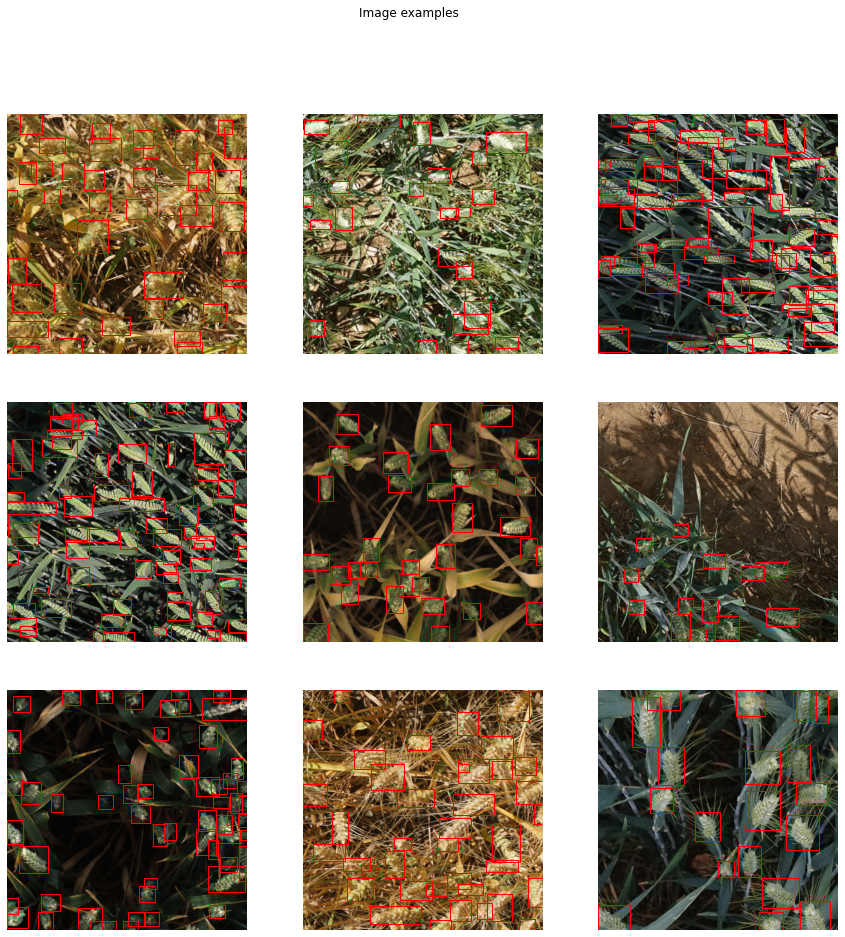

In [18]:
plot_images(df)

In [19]:
def hist_hover(dataframe, column, bins=30, title='', colors=["#94c8d8", "#ea5e51"], ):
  hist, edges = np.histogram(dataframe[column], bins = bins)
  
  hist_df = pd.DataFrame({column: hist,
                          "left": edges[:-1],
                          "right": edges[1:]})
  hist_df["interval"] = ["%d to %d" % (left, right) for left,
                         right in zip(hist_df["left"], hist_df["right"])]
                         
  src = ColumnDataSource(hist_df)
  plot = figure(plot_height = 400, plot_width = 600,
                title = title,
                x_axis_label = column,
                y_axis_label = "num_images")    
  plot.quad(bottom = 0, top = column,left = "left", 
            right = "right", source = src, fill_color = colors[0], 
            line_color = "#35838d", fill_alpha = 0.7,
            hover_fill_alpha = 0.7, hover_fill_color = colors[1])
  
  hover = HoverTool(tooltips = [('Interval', '@interval'), ('Count', str("@" + column))])
  plot.add_tools(hover)
  
  output_notebook()
  show(plot)

In [20]:
hist_hover(df, 'count', title='Number of wheat spikes per image')

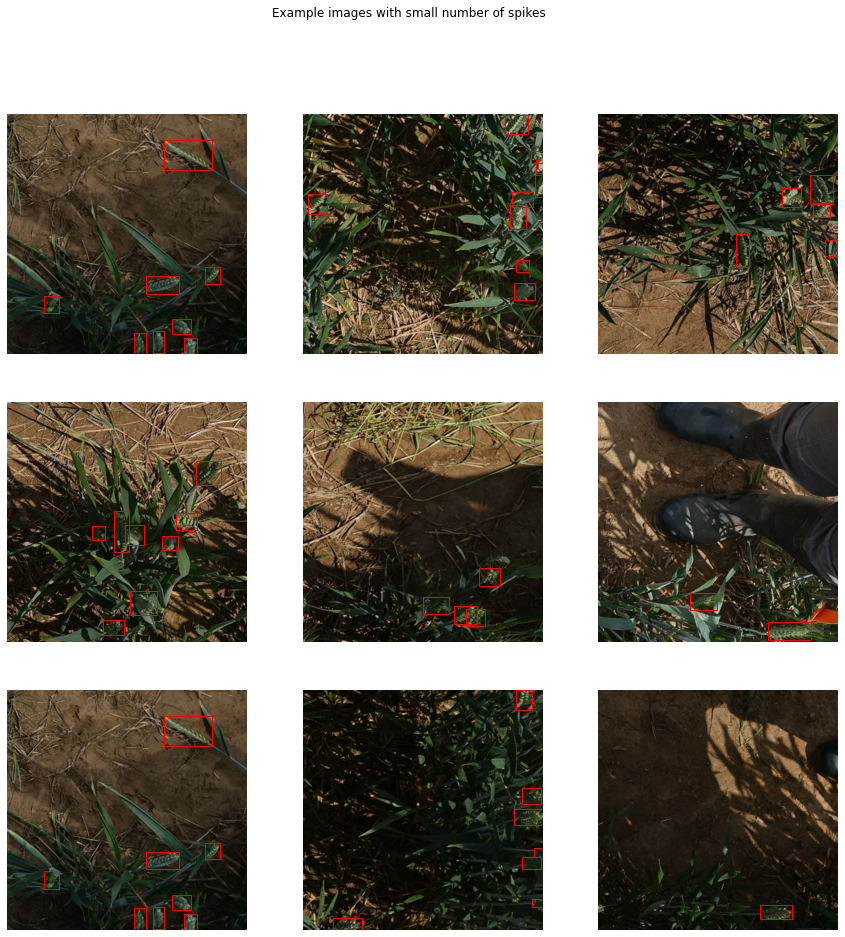

In [21]:
# Images with less spikes
less_spikes_ids = df[df['count'] < 10].image_name
plot_images(df[df.image_name.isin(less_spikes_ids)], title='Example images with small number of spikes')

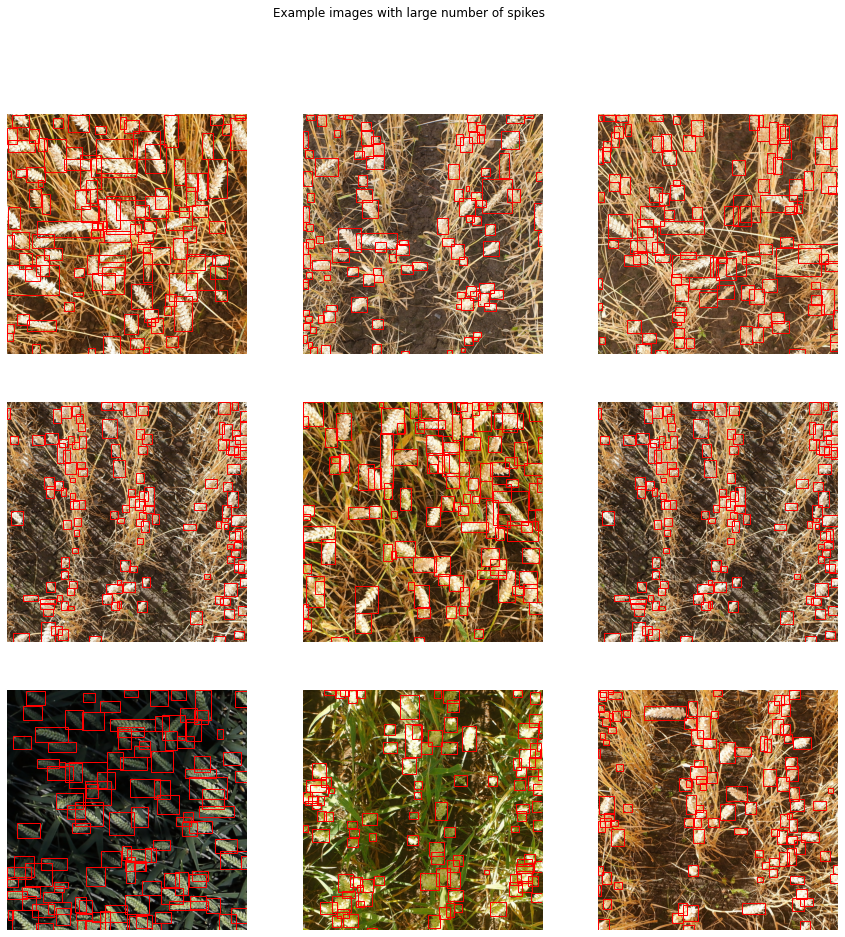

In [22]:
# Images with less spikes
more_spikes_ids = df[df['count'] > 100].image_name
plot_images(df[df.image_name.isin(more_spikes_ids)], title='Example images with large number of spikes')

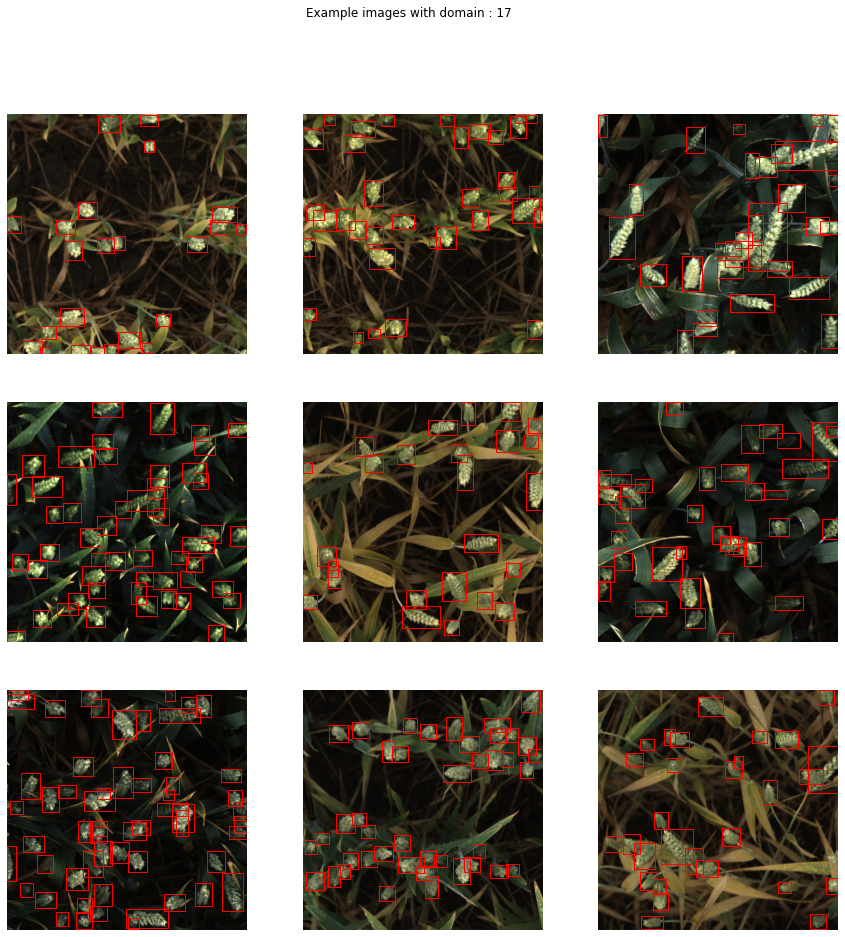

In [23]:
# Images of particular domain
idx = 17
domain = df[df['domain'] == idx].image_name
plot_images(df[df.image_name.isin(domain)], title=f'Example images with domain : {idx}')

In [24]:
df['max_area'] = max_area
df['min_area'] = min_area
df.head()

image_name  ... min_area
0  7b73239dfd89b06c03e1be81cc5074ec47ae048305ec63...  ...    644.0
1  0e37ccf64ccbd456f07dcfe110133018f324e5bdf63b08...  ...    575.0
2  89e0aa4148f0a9ff01e9e55c5a2bcbe294150444dbe43c...  ...   1280.0
3  fed8dde94c7a51de782b71f45c9115cdf7208cf7f33eee...  ...    700.0
4  8a593fc7894c37145d302bce36822bf21725088cf17b23...  ...    864.0

[5 rows x 6 columns]

In [25]:
print(df.max_area.max())

387960.0


In [26]:
hist_hover(df, 'max_area')

In [27]:
hist_hover(df, 'min_area')
# Note that images with no bbox have 0 area

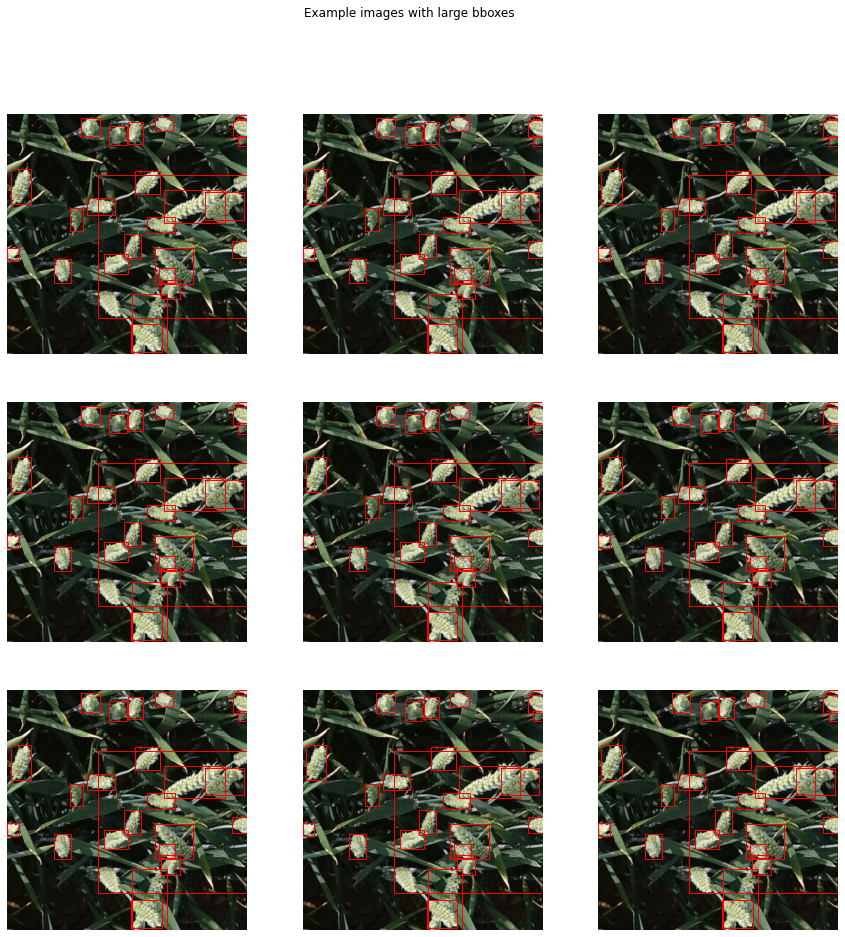

In [28]:
# Images with large
large_bboxes_ids = df[(df['max_area'] > 200000.0)].image_name
plot_images(df[df.image_name.isin(large_bboxes_ids)], title='Example images with large bboxes')

In [44]:
# Lets try some augmentation
def augs():
    return albumentations.Compose([
        albumentations.RandomCrop(width=450, height=450),
        albumentations.Flip(p=1.0)
    ], bbox_params = {
        'format': 'pascal_voc',
    })

In [45]:
def plot_aug_images(df, idx, augmentations):
  # reference: https://albumentations.ai/docs/examples/example_bboxes/
  fig, axs = plt.subplots(1, 2, figsize=(15,10))
  img_id = df.iloc[idx].image_name
  img = Image.open(train_dir + img_id + '.png')
  img = np.asarray(img)
  axs[0].imshow(img)
  axs[0].axis('off')
  bboxes_str = df.iloc[idx].BoxesString
  bboxes = bboxes_str.split(';')
  boxes = []
  class_labels = []
  for bbox in bboxes:
    if(bbox == 'no_box'):
      break
    box = list(map(float,bbox.split()))
    rect0 = patches.Rectangle((box[0], box[1]), box[2]-box[0], 
                            box[3]-box[1], linewidth=2, edgecolor='r', facecolor='none')
    axs[0].add_patch(rect0)
    h = box[3]-box[1]
    w = box[2]-box[0]
    box.append('1')
    boxes.append(box)
    class_labels.append('1')
  transformed = augmentations(image=img, bboxes=boxes)   
  transformed_image = transformed['image']
  transformed_bboxes = transformed['bboxes']
  
  axs[1].imshow(transformed_image)
  if(len(transformed_bboxes)==0):
    return 
  for bbox_a in transformed_bboxes:
    rect = patches.Rectangle((bbox_a[0], bbox_a[1]), bbox_a[2]-bbox_a[0], 
                            bbox_a[3]-bbox_a[1], linewidth=2, edgecolor='r', facecolor='none')
    axs[1].add_patch(rect)
    axs[1].axis('off')

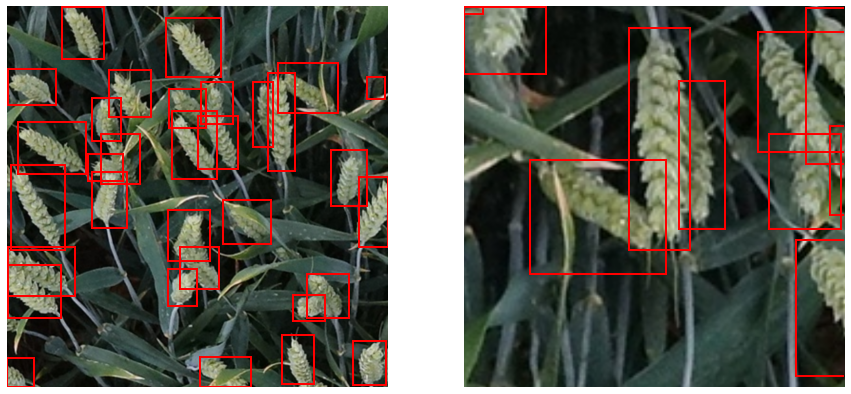

In [49]:
plot_aug_images(df , 100, augs())

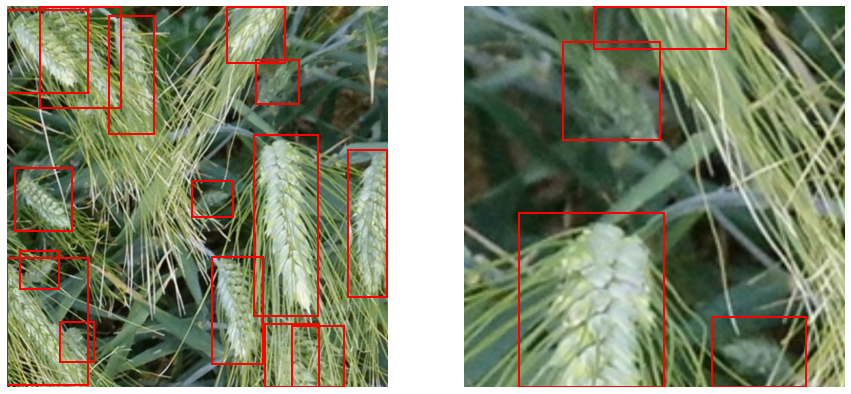

In [50]:
plot_aug_images(df , 120, augs())